# Cancellation prediction

## Business Understanding
The goal of this assignment is to predict the probability if a booking will be cancelled.

# Data understanding
The dataset will contain reservations that have been made in the last years. Based on the column "IS_CANCELLED" we can see if the reservation has been cancelled.

- RESERVATION_ID: Ok unique id to identify a reservation:
- CUSTOMER_ID: Ok unique id to identify a customer
- PAYING_CUSTOMER_ID: Maybe. unique id of the paying customer. If the booking is made by a touroperator then the customer_id can be different then the paying_customer_id
- RESORT_ID: Ok. the id of the resort (location)
- ARRIVAL_DATE: No. Data Leak. Date of arrival in YYYY-mm-dd
- DEPARTURE_DATE: No. Data Leak. Date of departure in YYYY-mm-dd
- RESERVATION_DATE: Ok. Date of reservation in YYYY-mm-dd
- STATUS: No. Data Leak.
- - -13: Definitive Cancelled: Reservation has been cancelled and everything has been settled.
- - -12: Cancelled: Reservation has been cancelled, waiting for settlements.
- - 12: Provisional: Reservation has been made, confirmed, but has not yet received any payment
- - 21: Defintive: Guest have made a payment, can be 1 euro or can be the full amount
- - 31: Checked-in: Guest is checked-in
- - 41: Checked-out: Guest checked out
- RESERVATIONCATEGORY_ID: Ok. unique id to identify a reservation category
- RESERVATIONCATEGORY_CODE: Ok (Compare with before. Which One has more data?). The code of the reservation category e.g.
- DISTRIBUTIONCHANNEL_ID: Ok. unique id to identify a distribution channel
- DC_CODE: OK. The code for the distribution channel, e.g. "int" for internet.
- CANCEL_DATE: No. Data Leak. The date of the cancellation.
- IS_CANCELLED: Ok. But if there is missing fill from status. If status = -12 or -13 then 1 else 0. It can be used as target
- DUE_AMOUNT: Data Leak? % Due is a good feature. Amount that still need to be paid
- AMOUNT_PAID: Data Leak? Amount paid on the reservation
- TOTAL: Data Leak? Total amount of the reservation
- N_MEMO_BEFORE_CANCELLATION: Data leak? How many notes (e.g. mail contact) are being made on the reservation before cancellation.
- NR_OF_PERSONS:Ok. Total amount of persons
- NR_OF_BABYS:Ok Amount of baby
- NR_OF_CHILDREN:Ok Amount of children
- NR_OF_ADULTS:Ok Amound of adults
- NR_OF_SENIORS:Ok Amount of seniors (55+)
- NR_OF_PETS:Ok Number of pets
- NR_OF_VERHICLES:Ok number of vehicles

# Steps
1. Visualize the data and use descriptive modelling. What are some factors why people cancel? Do some distribution channels cancel more?
2. Clean the data and give explanations why you remove certain rows
3. Create features and explain why you create those features
4. Prepare the data for a Machine Learning Model
5. Train and test the machine learning models (you can choose them yourself) and show the accuracy.
6. Discuss the results 

Remember, there is no right or wrong. It's all about showing your steps and logic.

In [82]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.set_option('display.max_columns', None) # Show all columns

df = pd.read_csv('../data/cancellations.csv')
df.head()

,RESERVATION_ID,CUSTOMER_ID,PAYING_CUSTOMER_ID,RESORT_ID,ARRIVAL_DATE,DEPARTURE_DATE,RESERVATION_DATE,STATUS,RESERVATIONCATEGORY_ID,RESERVATIONCATEGORY_CODE,DISTRIBUTIONCHANNEL_ID,DC_CODE,CANCEL_DATE,IS_CANCELLED,DUE_AMOUNT,AMOUNT_PAID,TOTAL,N_MEMO_BEFORE_CANCELLATION,NR_OF_PERSONS,NR_OF_BABYS,NR_OF_CHILDREN,NR_OF_ADULTS,NR_OF_SENIORS,NR_OF_PETS,NR_OF_VERHICLES
0,120119,132551,NaN,22,2012-01-01,2012-12-31,2011-11-02,41,2021,jp,6041,DBJP,NaN,0,0.0,2721.5,2721.5,0,1,0,0,0,1,0,0
1,120120,30153,NaN,22,2012-01-01,2012-12-31,2011-11-02,41,2021,jp,6041,DBJP,NaN,0,0.0,3204.0,3204.0,0,2,0,0,0,2,0,0
2,120121,30061,NaN,22,2012-01-01,2012-12-31,2011-11-02,41,2021,jp,6041,DBJP,NaN,0,0.0,2335.0,2335.0,0,2,0,0,0,2,0,0
3,120122,252023,NaN,22,2012-01-01,2012-12-31,2011-11-02,41,2021,jp,6041,DBJP,NaN,0,0.0,2579.0,2579.0,0,2,0,0,0,2,0,0
4,120123,144338,NaN,22,2012-01-01,2012-12-31,2011-11-02,41,2021,jp,6041,DBJP,NaN,0,0.0,2571.5,2571.5,0,6,0,0,0,6,0,0


# Explotary Data Analysis

In [62]:
df.describe()

,RESERVATION_ID,CUSTOMER_ID,PAYING_CUSTOMER_ID,RESORT_ID,STATUS,RESERVATIONCATEGORY_ID,DISTRIBUTIONCHANNEL_ID,IS_CANCELLED,DUE_AMOUNT,AMOUNT_PAID,TOTAL,N_MEMO_BEFORE_CANCELLATION,NR_OF_PERSONS,NR_OF_BABYS,NR_OF_CHILDREN,NR_OF_ADULTS,NR_OF_SENIORS,NR_OF_PETS,NR_OF_VERHICLES
count,3.358460e+05,3.358460e+05,1.363000e+03,335846.000000,335846.000000,335846.000000,335846.000000,335846.000000,324536.000000,324536.000000,324412.000000,335846.000000,335846.000000,335846.000000,335846.000000,335846.000000,335846.000000,335846.000000,335846.00000
mean,2.167994e+07,2.488421e+07,2.916009e+07,548.632978,39.306423,3467.220434,9402.322109,0.017386,19.519278,653.812626,689.193136,0.031726,4.872144,0.278893,1.043990,2.765270,0.776004,0.002784,0.59541
std,2.510320e+07,2.302545e+07,2.415443e+07,920.831537,8.075201,7626.717057,15891.684390,0.130705,1268.764283,2227.982886,1950.138081,0.319918,7.916059,0.583629,1.443962,7.245279,3.378914,0.056980,0.99943
min,2.200300e+04,1.000300e+04,7.689200e+04,1.000000,-13.000000,1.000000,42.000000,0.000000,-484190.790000,-11070.000000,-5400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,5.090873e+06,4.551200e+06,1.226721e+07,21.000000,41.000000,1.000000,4041.000000,0.000000,0.000000,222.687500,252.600000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000
50%,9.253262e+06,1.853737e+07,2.093336e+07,22.000000,41.000000,1.000000,4041.000000,0.000000,0.000000,462.000000,491.950000,0.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.00000
75%,3.516276e+07,3.585536e+07,6.232936e+07,2041.000000,41.000000,2.000000,8045.000000,0.000000,0.000000,803.677500,847.000000,0.000000,5.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.00000
max,9.039928e+07,7.840737e+07,7.772137e+07,8041.000000,41.000000,50021.000000,114041.000000,1.000000,184403.660000,484190.790000,446921.640000,16.000000,946.000000,12.000000,80.000000,946.000000,594.000000,5.000000,146.00000


In [60]:
df_c = df[df["IS_CANCELLED"] == 1].reset_index()

In [93]:
df_c["DISTRIBUTIONCHANNEL_ID"].value_counts()

DISTRIBUTIONCHANNEL_ID
4041     2409
42        894
42041     455
70041     307
68041     221
8055      219
4042      190
26041     161
16041     129
8045      110
88041     100
20041      93
8050       60
8048       59
46041      56
8054       54
36041      45
34041      41
8053       37
8046       32
86042      24
60041      21
8052       20
82041      17
78041      12
8049        9
96041       8
2041        8
98041       7
28041       7
40042       7
6041        6
80041       6
84041       4
10041       2
12041       2
52041       1
74041       1
58041       1
72041       1
90041       1
94041       1
66041       1
Name: count, dtype: int64

## Out of 43 Distribution Channels, those 5 are the most cancellations occur.

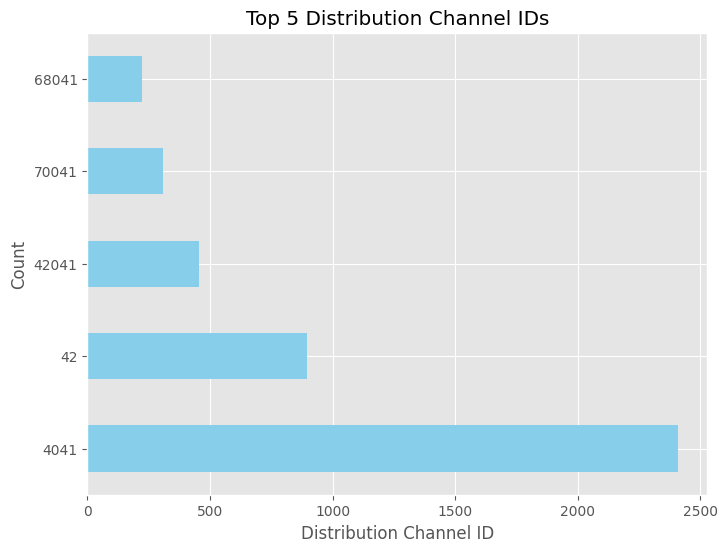

In [84]:
top_5 = df_c["DISTRIBUTIONCHANNEL_ID"].value_counts().nlargest(5)

# Plot the top 5 as a bar plot
top_5.plot(kind="barh", color='skyblue', figsize=(8, 6))

# Add titles and labels for clarity
plt.title('Top 5 Distribution Channel IDs')
plt.xlabel('Distribution Channel ID')
plt.ylabel('Count')

# Display the plot
plt.show()

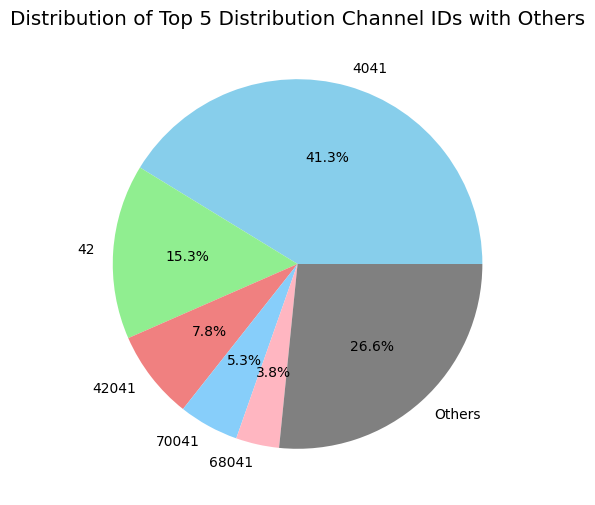

In [86]:
top_5 = df_c["DISTRIBUTIONCHANNEL_ID"].value_counts().nlargest(5)

others = pd.Series(df_c["DISTRIBUTIONCHANNEL_ID"].value_counts().iloc[5:].sum(), index=["Others"])

top_5_with_others = pd.concat([top_5, others])


plt.figure(figsize=(8, 6))
top_5_with_others.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink', 'gray'])
plt.title('Distribution of Top 5 Distribution Channel IDs with Others')
plt.ylabel('')  # Remove the y-label for better aesthetics

plt.show()

 ## We should be careful after 2-3 notes are added.

Text(0.5, 0, 'Number of Notes')

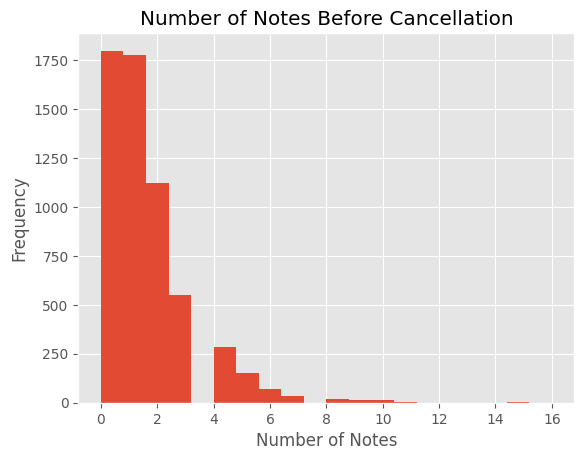

In [83]:

ax = df_c['N_MEMO_BEFORE_CANCELLATION'].plot(kind='hist',
                          bins=20,
                          title='Number of Notes Before Cancellation')
ax.set_xlabel('Number of Notes')

# Those resorts are problematic. However there are very less number of resorts. So it might not be a problem

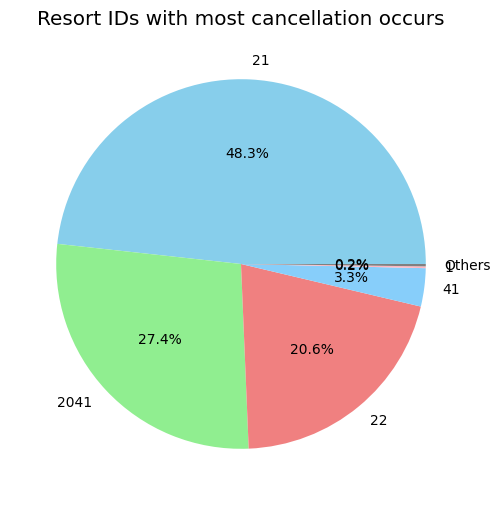

In [94]:
top_5 = df_c["RESORT_ID"].value_counts().nlargest(5)

others = pd.Series(df_c["RESORT_ID"].value_counts().iloc[5:].sum(), index=["Others"])

top_5_with_others = pd.concat([top_5, others])


plt.figure(figsize=(8, 6))
top_5_with_others.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink', 'gray'])
plt.title('Resort IDs with most cancellation occurs')
plt.ylabel('')  # Remove the y-label for better aesthetics

plt.show()

In [89]:
df_c["RESORT_ID"].unique()

array([  21,   22,   41,   23,    1,   24, 2041, 8041])

# Data Clean

Check is there a mismatch between is_cancelled and status column. Also it is definetly a data leak

In [3]:
df[df["IS_CANCELLED"] == 1][["STATUS", "IS_CANCELLED"]].value_counts()

STATUS  IS_CANCELLED
-13     1               5586
-12     1                253
Name: count, dtype: int64

In [4]:
df[df["IS_CANCELLED"] == 0][["STATUS", "IS_CANCELLED"]].value_counts()

STATUS  IS_CANCELLED
41      0               318350
21      0                 7233
12      0                 3412
31      0                 1012
Name: count, dtype: int64

## Percentage Data
1- Almost all of the PAYING_CUSTOMER_ID is missing drop it.
2- Money related columns can be filled.
3- Explain CANCEL_DATE later.

In [96]:
# - RESERVATIONCATEGORY_ID: Ok. unique id to identify a reservation category
# - RESERVATIONCATEGORY_CODE: Ok (Compare with before. Which One has more data?). The code of the reservation category e.g.
# Not necessary No missing value. One is enough
# STATUS - IS_CANCELLED: No necessary. No missing No. Data Leak.
(df.isna().sum()/df.shape[0] * 100).sort_values(ascending=False)
# Drop paying customer id, fill due amount, total, amount_paid

PAYING_CUSTOMER_ID            99.594159
CANCEL_DATE                   97.790654
TOTAL                          3.404537
AMOUNT_PAID                    3.367615
DUE_AMOUNT                     3.367615
DEPARTURE_DATE                 0.792625
ARRIVAL_DATE                   0.792625
RESERVATION_ID                 0.000000
CUSTOMER_ID                    0.000000
RESERVATIONCATEGORY_ID         0.000000
STATUS                         0.000000
RESERVATION_DATE               0.000000
RESORT_ID                      0.000000
DC_CODE                        0.000000
DISTRIBUTIONCHANNEL_ID         0.000000
RESERVATIONCATEGORY_CODE       0.000000
IS_CANCELLED                   0.000000
N_MEMO_BEFORE_CANCELLATION     0.000000
NR_OF_PERSONS                  0.000000
NR_OF_BABYS                    0.000000
NR_OF_CHILDREN                 0.000000
NR_OF_ADULTS                   0.000000
NR_OF_SENIORS                  0.000000
NR_OF_PETS                     0.000000
NR_OF_VERHICLES                0.000000


## CANCEL_DATE is Data leak

In [7]:

df[["CANCEL_DATE", "IS_CANCELLED"]]

,CANCEL_DATE,IS_CANCELLED
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
335841,NaN,0
335842,NaN,0
335843,NaN,0
335844,NaN,0


In [8]:
df[df["IS_CANCELLED"] == 1][["CANCEL_DATE", "IS_CANCELLED"]]

,CANCEL_DATE,IS_CANCELLED
1609,2011-12-30,1
1774,2012-01-06,1
1816,2012-01-01,1
1944,2012-01-24,1
1948,2012-01-12,1
...,...,...
334974,2013-10-09,1
334980,2013-09-20,1
335793,2012-01-13,1
335808,2012-01-13,1


In [9]:
df[df["IS_CANCELLED"] == 1][["N_MEMO_BEFORE_CANCELLATION", "IS_CANCELLED"]]

,N_MEMO_BEFORE_CANCELLATION,IS_CANCELLED
1609,2,1
1774,1,1
1816,2,1
1944,3,1
1948,0,1
...,...,...
334974,0,1
334980,0,1
335793,0,1
335808,0,1


## Investating N_MEMO_BEFORE_CANCELLATION can be data leak or not

In [10]:
df[df["IS_CANCELLED"] == 0][["N_MEMO_BEFORE_CANCELLATION", "IS_CANCELLED"]]

,N_MEMO_BEFORE_CANCELLATION,IS_CANCELLED
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
335841,0,0
335842,0,0
335843,0,0
335844,0,0


In [11]:
# No data leak
df[(df["N_MEMO_BEFORE_CANCELLATION"] > 0) & (df["IS_CANCELLED"] == 1)][["N_MEMO_BEFORE_CANCELLATION", "IS_CANCELLED"]]

,N_MEMO_BEFORE_CANCELLATION,IS_CANCELLED
1609,2,1
1774,1,1
1816,2,1
1944,3,1
1982,4,1
...,...,...
334568,2,1
334611,2,1
334929,1,1
334950,2,1


# Same information no additional value

In [12]:
df[["RESERVATIONCATEGORY_ID", "RESERVATIONCATEGORY_CODE"]]

,RESERVATIONCATEGORY_ID,RESERVATIONCATEGORY_CODE
0,2021,jp
1,2021,jp
2,2021,jp
3,2021,jp
4,2021,jp
...,...,...
335841,10031,tc
335842,10030,ec
335843,10030,ec
335844,1,res


## Choose the one with less missing values
## Does not matter which drop. Choosing dropping RESERVATIONCATEGORY_CODE since it is categorical feature.

In [13]:
df[["RESERVATIONCATEGORY_ID", "RESERVATIONCATEGORY_CODE"]].isnull().sum()

RESERVATIONCATEGORY_ID      0
RESERVATIONCATEGORY_CODE    0
dtype: int64

## Selecting Dropping Columns

In [14]:
data_leak_columns = ["ARRIVAL_DATE", "DEPARTURE_DATE", "STATUS", "CANCEL_DATE",
                     # "N_MEMO_BEFORE_CANCELLATION"
                     ]
print(df["PAYING_CUSTOMER_ID"].isnull().sum()/len(df))
data_leak_columns.append("PAYING_CUSTOMER_ID")
data_leak_columns.append("RESERVATIONCATEGORY_CODE")

0.9959415922774129


In [15]:
data = df.drop(columns=data_leak_columns)

In [16]:
data

,RESERVATION_ID,CUSTOMER_ID,RESORT_ID,RESERVATION_DATE,RESERVATIONCATEGORY_ID,DISTRIBUTIONCHANNEL_ID,DC_CODE,IS_CANCELLED,DUE_AMOUNT,AMOUNT_PAID,TOTAL,N_MEMO_BEFORE_CANCELLATION,NR_OF_PERSONS,NR_OF_BABYS,NR_OF_CHILDREN,NR_OF_ADULTS,NR_OF_SENIORS,NR_OF_PETS,NR_OF_VERHICLES
0,120119,132551,22,2011-11-02,2021,6041,DBJP,0,0.0,2721.50,2721.50,0,1,0,0,0,1,0,0
1,120120,30153,22,2011-11-02,2021,6041,DBJP,0,0.0,3204.00,3204.00,0,2,0,0,0,2,0,0
2,120121,30061,22,2011-11-02,2021,6041,DBJP,0,0.0,2335.00,2335.00,0,2,0,0,0,2,0,0
3,120122,252023,22,2011-11-02,2021,6041,DBJP,0,0.0,2579.00,2579.00,0,2,0,0,0,2,0,0
4,120123,144338,22,2011-11-02,2021,6041,DBJP,0,0.0,2571.50,2571.50,0,6,0,0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335841,1058010,1614029,22,2012-04-24,10031,8053,TOTC,0,0.0,253.05,294.85,0,3,0,0,0,3,0,0
335842,1908284,2888034,21,2012-06-16,10030,8049,TOEU,0,0.0,63.00,63.00,0,6,0,0,0,6,0,0
335843,1908289,2888038,21,2012-06-16,10030,8049,TOEU,0,0.0,52.50,52.50,0,5,0,0,0,5,0,0
335844,1252434,8159190,22,2012-05-19,1,4042,DBREC,0,0.0,111.45,111.45,0,3,0,0,0,3,0,0


## How should I fill money features?

In [17]:
data[["DUE_AMOUNT"]].value_counts()/len(data[["DUE_AMOUNT"]])

DUE_AMOUNT
 0.00         0.882735
-18.50        0.001024
 25.00        0.000804
 22.50        0.000783
 155.00       0.000554
                ...   
-93530.69     0.000003
-102759.12    0.000003
-121039.17    0.000003
-127220.45    0.000003
-130446.63    0.000003
Name: count, Length: 11084, dtype: float64

In [18]:
data[["TOTAL"]].value_counts()/len(data[["DUE_AMOUNT"]])

TOTAL    
 0.00        0.007128
 26.40       0.002287
 78.95       0.001605
 44.00       0.001435
 33.00       0.001274
               ...   
 30949.57    0.000003
 30787.60    0.000003
 30552.10    0.000003
 30259.80    0.000003
-200.00      0.000003
Name: count, Length: 55986, dtype: float64

In [19]:
data[["AMOUNT_PAID"]].value_counts()/len(data[["DUE_AMOUNT"]])

AMOUNT_PAID
 0.00          0.019738
 26.40         0.002403
 78.95         0.001507
 44.00         0.001492
 33.00         0.001388
                 ...   
 105089.60     0.000003
 95251.80      0.000003
 87865.00      0.000003
 85425.39      0.000003
-394.20        0.000003
Name: count, Length: 69466, dtype: float64

In [20]:
df['DUE_AMOUNT'].median()

np.float64(0.0)

In [ ]:
data['DUE_AMOUNT'].fillna(data['DUE_AMOUNT'].median(), inplace=True)
data['AMOUNT_PAID'].fillna(data['AMOUNT_PAID'].mean(), inplace=True)
data['TOTAL'].fillna(data['TOTAL'].mean(), inplace=True)

In [22]:
data.isnull().sum()

RESERVATION_ID                0
CUSTOMER_ID                   0
RESORT_ID                     0
RESERVATION_DATE              0
RESERVATIONCATEGORY_ID        0
DISTRIBUTIONCHANNEL_ID        0
DC_CODE                       0
IS_CANCELLED                  0
DUE_AMOUNT                    0
AMOUNT_PAID                   0
TOTAL                         0
N_MEMO_BEFORE_CANCELLATION    0
NR_OF_PERSONS                 0
NR_OF_BABYS                   0
NR_OF_CHILDREN                0
NR_OF_ADULTS                  0
NR_OF_SENIORS                 0
NR_OF_PETS                    0
NR_OF_VERHICLES               0
dtype: int64

# Handle date column

In [23]:
data.dtypes

RESERVATION_ID                  int64
CUSTOMER_ID                     int64
RESORT_ID                       int64
RESERVATION_DATE               object
RESERVATIONCATEGORY_ID          int64
DISTRIBUTIONCHANNEL_ID          int64
DC_CODE                        object
IS_CANCELLED                    int64
DUE_AMOUNT                    float64
AMOUNT_PAID                   float64
TOTAL                         float64
N_MEMO_BEFORE_CANCELLATION      int64
NR_OF_PERSONS                   int64
NR_OF_BABYS                     int64
NR_OF_CHILDREN                  int64
NR_OF_ADULTS                    int64
NR_OF_SENIORS                   int64
NR_OF_PETS                      int64
NR_OF_VERHICLES                 int64
dtype: object

In [25]:
data['RESERVATION_DATE']

0         2011-11-02
1         2011-11-02
2         2011-11-02
3         2011-11-02
4         2011-11-02
             ...    
335841    2012-04-24
335842    2012-06-16
335843    2012-06-16
335844    2012-05-19
335845    2012-04-16
Name: RESERVATION_DATE, Length: 335846, dtype: object

In [26]:
data['RESERVATION_DATE'] = pd.to_datetime(data['RESERVATION_DATE'], format='%Y-%m-%d')

In [28]:
data['dayofmonth'] = data['RESERVATION_DATE'].dt.day
data['month'] = data['RESERVATION_DATE'].dt.month
data['year'] = data['RESERVATION_DATE'].dt.year

## May be some of the day weeks, quarters, day of the year, week of the year are special. Weekends, Summer, other holiday days?

In [ ]:
data['dayofweek'] = data['RESERVATION_DATE'].dt.dayofweek
data['quarter'] = data['RESERVATION_DATE'].dt.quarter
data['dayofyear'] = data['RESERVATION_DATE'].dt.dayofyear
data['weekofyear'] = data['RESERVATION_DATE'].dt.isocalendar().week

We Created all the features from RESERVATION_DATE, we can drop it now.

In [29]:
data.drop(columns=["RESERVATION_DATE"], inplace=True)

# Handle one categorical colum

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
data['DC_CODE_encoded'] = ordinal_encoder.fit_transform(data[['DC_CODE']])


In [37]:
data.drop(columns = ["DC_CODE"], inplace=True)

In [39]:
data.head()

,RESERVATION_ID,CUSTOMER_ID,RESORT_ID,RESERVATIONCATEGORY_ID,DISTRIBUTIONCHANNEL_ID,IS_CANCELLED,DUE_AMOUNT,AMOUNT_PAID,TOTAL,N_MEMO_BEFORE_CANCELLATION,NR_OF_PERSONS,NR_OF_BABYS,NR_OF_CHILDREN,NR_OF_ADULTS,NR_OF_SENIORS,NR_OF_PETS,NR_OF_VERHICLES,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,DC_CODE_encoded
0,120119,132551,22,2021,6041,0,0.0,2721.5,2721.5,0,1,0,0,0,1,0,0,2,4,11,2011,306,2,44,10.0
1,120120,30153,22,2021,6041,0,0.0,3204.0,3204.0,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
2,120121,30061,22,2021,6041,0,0.0,2335.0,2335.0,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
3,120122,252023,22,2021,6041,0,0.0,2579.0,2579.0,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
4,120123,144338,22,2021,6041,0,0.0,2571.5,2571.5,0,6,0,0,0,6,0,0,2,4,11,2011,306,2,44,10.0


In [40]:
data.dtypes

RESERVATION_ID                  int64
CUSTOMER_ID                     int64
RESORT_ID                       int64
RESERVATIONCATEGORY_ID          int64
DISTRIBUTIONCHANNEL_ID          int64
IS_CANCELLED                    int64
DUE_AMOUNT                    float64
AMOUNT_PAID                   float64
TOTAL                         float64
N_MEMO_BEFORE_CANCELLATION      int64
NR_OF_PERSONS                   int64
NR_OF_BABYS                     int64
NR_OF_CHILDREN                  int64
NR_OF_ADULTS                    int64
NR_OF_SENIORS                   int64
NR_OF_PETS                      int64
NR_OF_VERHICLES                 int64
dayofweek                       int32
quarter                         int32
month                           int32
year                            int32
dayofyear                       int32
dayofmonth                      int32
weekofyear                     UInt32
DC_CODE_encoded               float64
dtype: object

# Data Split and prepare

In [42]:
y = data.IS_CANCELLED
X= data.drop(['IS_CANCELLED'], axis=1).copy()

In [43]:
X.head()

,RESERVATION_ID,CUSTOMER_ID,RESORT_ID,RESERVATIONCATEGORY_ID,DISTRIBUTIONCHANNEL_ID,DUE_AMOUNT,AMOUNT_PAID,TOTAL,N_MEMO_BEFORE_CANCELLATION,NR_OF_PERSONS,NR_OF_BABYS,NR_OF_CHILDREN,NR_OF_ADULTS,NR_OF_SENIORS,NR_OF_PETS,NR_OF_VERHICLES,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,DC_CODE_encoded
0,120119,132551,22,2021,6041,0.0,2721.5,2721.5,0,1,0,0,0,1,0,0,2,4,11,2011,306,2,44,10.0
1,120120,30153,22,2021,6041,0.0,3204.0,3204.0,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
2,120121,30061,22,2021,6041,0.0,2335.0,2335.0,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
3,120122,252023,22,2021,6041,0.0,2579.0,2579.0,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
4,120123,144338,22,2021,6041,0.0,2571.5,2571.5,0,6,0,0,0,6,0,0,2,4,11,2011,306,2,44,10.0


In [44]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: IS_CANCELLED, dtype: int64

In [46]:
# Break off validation set from training data
from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
#                                                                 random_state=42)

In [51]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 5 # 4 = 80% train, 20% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:

    # get cross validation score for each model:
    cv_results = cross_val_score(model,
                                 X, y,
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

DT_model cross validation accuarcy score: 0.9947 +/- 0.0001 (std) min: 0.9945, max: 0.9948
RF_model cross validation accuarcy score: 0.9956 +/- 0.0002 (std) min: 0.9953, max: 0.9959
LR_model cross validation accuarcy score: 0.9826 +/- 0.0003 (std) min: 0.9823, max: 0.9829
XGB_model cross validation accuarcy score: 0.9975 +/- 0.0001 (std) min: 0.9974, max: 0.9977


In [52]:
X X X X X

,RESERVATION_ID,CUSTOMER_ID,RESORT_ID,RESERVATIONCATEGORY_ID,DISTRIBUTIONCHANNEL_ID,DUE_AMOUNT,AMOUNT_PAID,TOTAL,N_MEMO_BEFORE_CANCELLATION,NR_OF_PERSONS,NR_OF_BABYS,NR_OF_CHILDREN,NR_OF_ADULTS,NR_OF_SENIORS,NR_OF_PETS,NR_OF_VERHICLES,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,DC_CODE_encoded
0,120119,132551,22,2021,6041,0.0,2721.50,2721.50,0,1,0,0,0,1,0,0,2,4,11,2011,306,2,44,10.0
1,120120,30153,22,2021,6041,0.0,3204.00,3204.00,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
2,120121,30061,22,2021,6041,0.0,2335.00,2335.00,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
3,120122,252023,22,2021,6041,0.0,2579.00,2579.00,0,2,0,0,0,2,0,0,2,4,11,2011,306,2,44,10.0
4,120123,144338,22,2021,6041,0.0,2571.50,2571.50,0,6,0,0,0,6,0,0,2,4,11,2011,306,2,44,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335841,1058010,1614029,22,10031,8053,0.0,253.05,294.85,0,3,0,0,0,3,0,0,1,2,4,2012,115,24,17,52.0
335842,1908284,2888034,21,10030,8049,0.0,63.00,63.00,0,6,0,0,0,6,0,0,5,2,6,2012,168,16,24,35.0
335843,1908289,2888038,21,10030,8049,0.0,52.50,52.50,0,5,0,0,0,5,0,0,5,2,6,2012,168,16,24,35.0
335844,1252434,8159190,22,1,4042,0.0,111.45,111.45,0,3,0,0,0,3,0,0,5,2,5,2012,140,19,20,11.0
